In [33]:
import yfinance as yf
import pandas as pd
import os

In [34]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [35]:
sp500.index = pd.to_datetime(sp500.index, utc = True)

In [36]:
sp500.index

DatetimeIndex(['1927-12-30 05:00:00+00:00', '1928-01-03 05:00:00+00:00',
               '1928-01-04 05:00:00+00:00', '1928-01-05 05:00:00+00:00',
               '1928-01-06 05:00:00+00:00', '1928-01-09 05:00:00+00:00',
               '1928-01-10 05:00:00+00:00', '1928-01-11 05:00:00+00:00',
               '1928-01-12 05:00:00+00:00', '1928-01-13 05:00:00+00:00',
               ...
               '2024-07-10 04:00:00+00:00', '2024-07-11 04:00:00+00:00',
               '2024-07-12 04:00:00+00:00', '2024-07-15 04:00:00+00:00',
               '2024-07-16 04:00:00+00:00', '2024-07-17 04:00:00+00:00',
               '2024-07-18 04:00:00+00:00', '2024-07-19 04:00:00+00:00',
               '2024-07-22 04:00:00+00:00', '2024-07-23 04:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=24255, freq=None)

<Axes: xlabel='Date'>

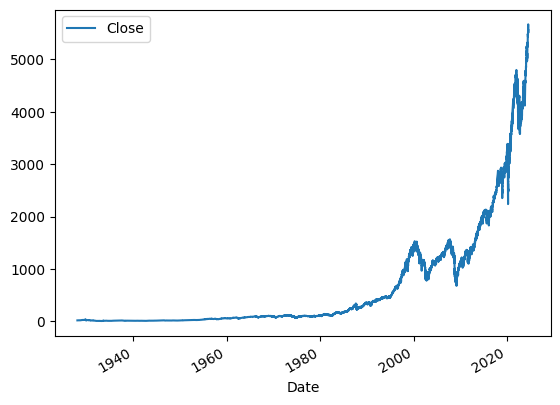

In [37]:
sp500.plot.line(y="Close", use_index=True)

In [38]:
sp500.drop(columns = ['Dividends','Stock Splits'] , inplace = True)

In [39]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [40]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [41]:
sp500 = sp500.loc["1990-01-01":].copy()

In [42]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [43]:
test

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2024-02-29 05:00:00+00:00,5085.359863,5104.990234,5061.890137,5096.270020,5219740000,5137.080078,1
2024-03-01 05:00:00+00:00,5098.509766,5140.330078,5094.160156,5137.080078,4748110000,5130.950195,0
2024-03-04 05:00:00+00:00,5130.990234,5149.669922,5127.180176,5130.950195,4758440000,5078.649902,0
2024-03-05 05:00:00+00:00,5110.520020,5114.540039,5056.819824,5078.649902,4418410000,5104.759766,1
2024-03-06 05:00:00+00:00,5108.029785,5127.970215,5092.220215,5104.759766,4559050000,5157.359863,1
...,...,...,...,...,...,...,...
2024-07-17 04:00:00+00:00,5610.069824,5622.490234,5584.810059,5588.270020,4246450000,5544.589844,0
2024-07-18 04:00:00+00:00,5608.560059,5614.049805,5522.810059,5544.589844,4007510000,5505.000000,0
2024-07-19 04:00:00+00:00,5543.370117,5557.500000,5497.040039,5505.000000,3760570000,5564.410156,1


In [47]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
import pandas as pd
preds = pd.Series(preds, index = test.index)
precision_score(test['Target'], preds)

0.5454545454545454

<Axes: xlabel='Date'>

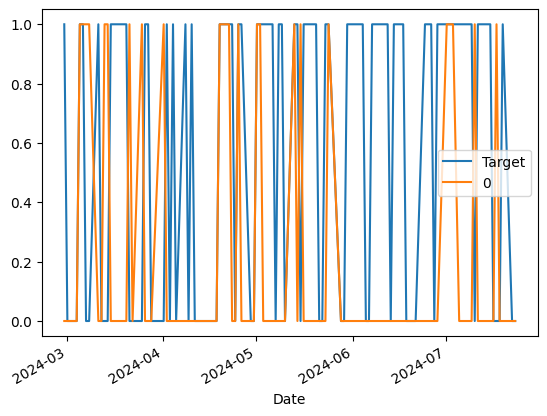

In [48]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [49]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [50]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [51]:
predictions = backtest(sp500, model, predictors)

In [52]:
predictions["Predictions"].value_counts()

Predictions
0    3609
1    2596
Name: count, dtype: int64

In [53]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [54]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.535375
0    0.464625
Name: count, dtype: float64

In [55]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [56]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [57]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 05:00:00+00:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 05:00:00+00:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 05:00:00+00:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 05:00:00+00:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 05:00:00+00:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-17 04:00:00+00:00,5610.069824,5622.490234,5584.810059,5588.270020,4246450000,5544.589844,0,0.992987,1.0,0.994829,3.0,1.046250,41.0,1.154124,142.0,1.310503,532.0
2024-07-18 04:00:00+00:00,5608.560059,5614.049805,5522.810059,5544.589844,4007510000,5505.000000,0,0.996076,0.0,0.988459,3.0,1.036345,40.0,1.144149,142.0,1.299557,531.0
2024-07-19 04:00:00+00:00,5543.370117,5557.500000,5497.040039,5505.000000,3760570000,5564.410156,1,0.996417,0.0,0.985278,2.0,1.027555,39.0,1.135072,141.0,1.289587,531.0


In [58]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [59]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [60]:
predictions = backtest(sp500, model, new_predictors)

In [61]:
predictions["Predictions"].value_counts()

Predictions
0.0    4367
1.0     838
Name: count, dtype: int64

In [62]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5751789976133651

In [63]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.545053
0    0.454947
Name: count, dtype: float64

In [64]:
predictions

,Target,Predictions
Date,,
2003-11-14 05:00:00+00:00,0,0.0
2003-11-17 05:00:00+00:00,0,1.0
2003-11-18 05:00:00+00:00,1,1.0
2003-11-19 05:00:00+00:00,0,0.0
2003-11-20 05:00:00+00:00,1,1.0
...,...,...
2024-07-17 04:00:00+00:00,0,0.0
2024-07-18 04:00:00+00:00,0,0.0
2024-07-19 04:00:00+00:00,1,0.0
